In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrow
import matplotlib as mpl

sys.path.append("../../unfolding/")

from Application_functions import *
from functions_folding import *
from Unfolding import Unfolding
NA = np.newaxis

In [2]:
def load_h5(filename):
    hf = h5py.File(filename, 'r')
    d_CC = np.array(hf.get("radii"))
    E_init = np.array(hf.get("E_init"))
    E_final = np.array(hf.get("E_final"))
    functional = np.array(hf.get("functional"))
    basis_set = np.array(hf.get("basis_set"))
    geometries = np.array(hf.get("geometries"))
    hf.close()
    return d_CC, E_init, E_final, geometries

In [3]:
### Load the data for the hinge_0 closing path with F as halogen ###
d_CC_F, E_init_F, E_final_F, geometries_F = load_h5("../../data/C60_closing/hinge_0_F.h5")
d_CC_Cl, E_init_Cl, E_final_Cl, geometries_Cl = load_h5("../../data/C60_closing/hinge_0_Cl.h5")
d_CC_F_inside, E_init_F_inside, E_final_F_inside, geometries_F_inside = load_h5("../../data/C60_closing//hinge_0_F_inside.h5")
dual_unfolding, graph_unfolding, graph_unfolding_faces, vertices_final, bonds_toBe, lengths_toBe, angles_f, opt_geom, halogen_positions, neighbours, graph_faces = read_unfolding("../../data/unfolding_graph/C60data.h5")

In [4]:
C60 = Unfolding(dual_unfolding, graph_unfolding_faces, graph_faces, graph_unfolding, neighbours, halogen_positions=halogen_positions, root_node=0, bonds_toBe=bonds_toBe, angles_f=angles_f)

In [5]:
def three_dist(unfolding):
    dist_a, dist_b, dist_c = np.linalg.norm(unfolding.vertex_coords[15] - unfolding.vertex_coords[35]) , np.linalg.norm(unfolding.vertex_coords[21] - unfolding.vertex_coords[22]), np.linalg.norm(unfolding.vertex_coords[28] - unfolding.vertex_coords[29])  
    mean_dist = np.mean([dist_a,dist_b,dist_c])
    return np.round(mean_dist,3)

In [6]:
def distances(geometries, graph):
    dist = np.zeros([geometries.shape[0],graph.shape[0],graph.shape[1]])
    for i in range(geometries.shape[0]):
        geometry = geometries[i][-1]
        d = np.linalg.norm(geometry[:60,NA,:] - geometry[C60.graph_unfolding_array],axis=-1)
        dist[i] = d
    return dist

In [7]:
def dist_pair(pair, dist, graph):
    id_y = np.where(graph[pair[0]] == pair[1])[0]
    if len(id_y) < 1:
        print("Vertex %i is not a neighbour of vertex %i" %(pair[1],pair[0]))
    return dist[:,pair[0],id_y].flatten()

In [8]:
def chain_dist(chain, dist, graph):
    dist_chain = np.zeros([len(chain)-1,dist.shape[0]])
    for i in range(len(chain)-1):
        pair = [chain[i], chain[i+1]]
        tmp = dist_pair(pair, dist, graph)
        dist_chain[i] = tmp
    return dist_chain

In [9]:
def fit_plane(points):
    N = len(points)
    #points = old_points - (np.sum(old_points,axis=0)/N)[NA,:]
    CM = (np.sum(points,axis=0)/N)
    M = points - CM[NA,:]
    U, S, V = np.linalg.svd(M)
    n = V[np.argmin(S)]
    err = np.sum((M@n)**2)
    return n, err

In [10]:
def plot_plane(n, CM, ax, face, geometry):
    verts=[geometry[face]]
    
    # plot plane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                      np.arange(ylim[0], ylim[1]))

    d =  CM @ n_0
    Z = np.zeros(X.shape)

    for r in range(X.shape[0]):
        for c in range(X.shape[1]):
            #z = (-normal(1)*xx - normal(2)*yy - d)/normal(3) 
            #Z[r,c] = n_0[0] * X[r,c] + n_0[1] * Y[r,c] + n_0[2]
            Z[r,c] = (- n_0[0] * X[r,c] - n_0[1] * Y[r,c] + d)/n_0[2]
    #ax.plot_wireframe(X - CM[0],Y-CM[1],Z- CM[2], color='k')
    ax.plot_wireframe(X,Y,Z, color='k')
    ax.add_collection3d(Poly3DCollection(verts))
    return ax

In [11]:
def plot_graph_3D(graph ,elec, azim, ax,xlim = [-8,8], ylim = [-8,8], zlim=[0,8], draw_dist=False, big_HF=None,size=40):
    X = graph.vertex_coords
    #%matplotlib notebook
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.scatter(X[:-graph.periphery,0],X[:-graph.periphery,1],X[:-graph.periphery,2], color="r",s=size)
    colors = np.zeros([graph.periphery,3])
    colors[:,1][np.where(graph.periphery_type == 0.)] = 1.
    colors[:,2][np.where(graph.periphery_type == 1.)] = 1.
    colors[:,0][np.where(graph.periphery_type == 1.)] = 0.3
    ax.scatter(X[-graph.periphery:,0],X[-graph.periphery:,1],X[-graph.periphery:,2], color=colors, s=size)
    if big_HF != None:
        big = np.array([60,63,64,67,68,71],dtype=int)
        for vertex in big:
            ax.scatter(X[vertex,0],X[vertex,1],X[vertex,2], color=colors[vertex-graph.n_carbon],s=big_HF)
    
    for vertex in range(len(graph.graph_unfolding)):
        for neighbour in graph.graph_unfolding[vertex]:
            line = np.vstack([graph.vertex_coords[vertex],graph.vertex_coords[neighbour]]).T
            ax.plot(line[0],line[1],line[2],color="k")
    
    for vertex in range(graph.periphery):
        line = np.vstack([graph.vertex_coords[graph.parent_atom[vertex]],graph.vertex_coords[vertex + graph.n_carbon]]).T
        ax.plot(line[0],line[1],line[2],color="k")
    
    phi = np.linspace(0, 2*np.pi, len(graph.graph_unfolding_faces))
    rgb_cycle = np.vstack((            # Three sinusoids
        .5*(1+np.cos(phi          )), # scaled to [0,1]
        .5*(1+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
        .5*(1+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)
    
    if draw_dist == True:
        line = np.vstack([graph.vertex_coords[15], graph.vertex_coords[35]]).T
        ax = add_interval(ax, line[0], line[1], line[2])
        line = np.vstack([graph.vertex_coords[21], graph.vertex_coords[22]]).T
        ax = add_interval(ax, line[0], line[1], line[2])
        line = np.vstack([graph.vertex_coords[28], graph.vertex_coords[29]]).T
        ax = add_interval(ax, line[0], line[1], line[2])
    
    rgb_cycle = np.hstack([rgb_cycle,np.ones([rgb_cycle.shape[0],1])*0.3])
    
    for c,face in enumerate(graph.graph_unfolding_faces):
        verts=[X[face]]
        ax.add_collection3d(Poly3DCollection(verts,facecolors=rgb_cycle[c]))
    print(three_dist(graph))
    return ax, three_dist(graph)

In [12]:
def add_interval(ax, xdata, ydata, zdata,  caps="  ", color="r"):
    ax.plot(xdata, ydata, zdata, color=color, linewidth=3.,linestyle="dashed")
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color' : color
    }
    ax.text(xdata[0], ydata[0], zdata[0], caps[0], color=color,fontweight='bold',fontsize=18)
    ax.text(xdata[1], ydata[1], zdata[1], caps[1], color=color,fontweight='bold',fontsize=18)
    #a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0], zdata[0]), **anno_args)
    #a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1], zdata[1]), **anno_args)
    return ax

In [13]:
dists_F = distances(geometries_F, C60.graph_unfolding_array)
dists_Cl = distances(geometries_Cl, C60.graph_unfolding_array)
dists_F_inside = distances(geometries_F_inside, C60.graph_unfolding_array)

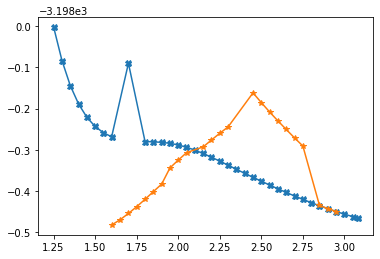

In [14]:
plt.plot(d_CC_F, E_final_F,marker="X")
plt.plot(d_CC_F_inside[np.where(E_final_F_inside != 0.)], E_final_F_inside[np.where(E_final_F_inside != 0.)], marker="*")
#plt.savefig("../../Illustrations/quick_E.pdf")

In [15]:
face_0 = C60.graph_unfolding_faces[-8]
geometry = geometries_F[10,1]
face_0_verts = geometry[face_0]
CM = (np.sum(face_0_verts, axis=0)/len(face_0_verts))
n_0, err_0 = fit_plane(face_0_verts)
verts=[geometry[face_0]]

2.651


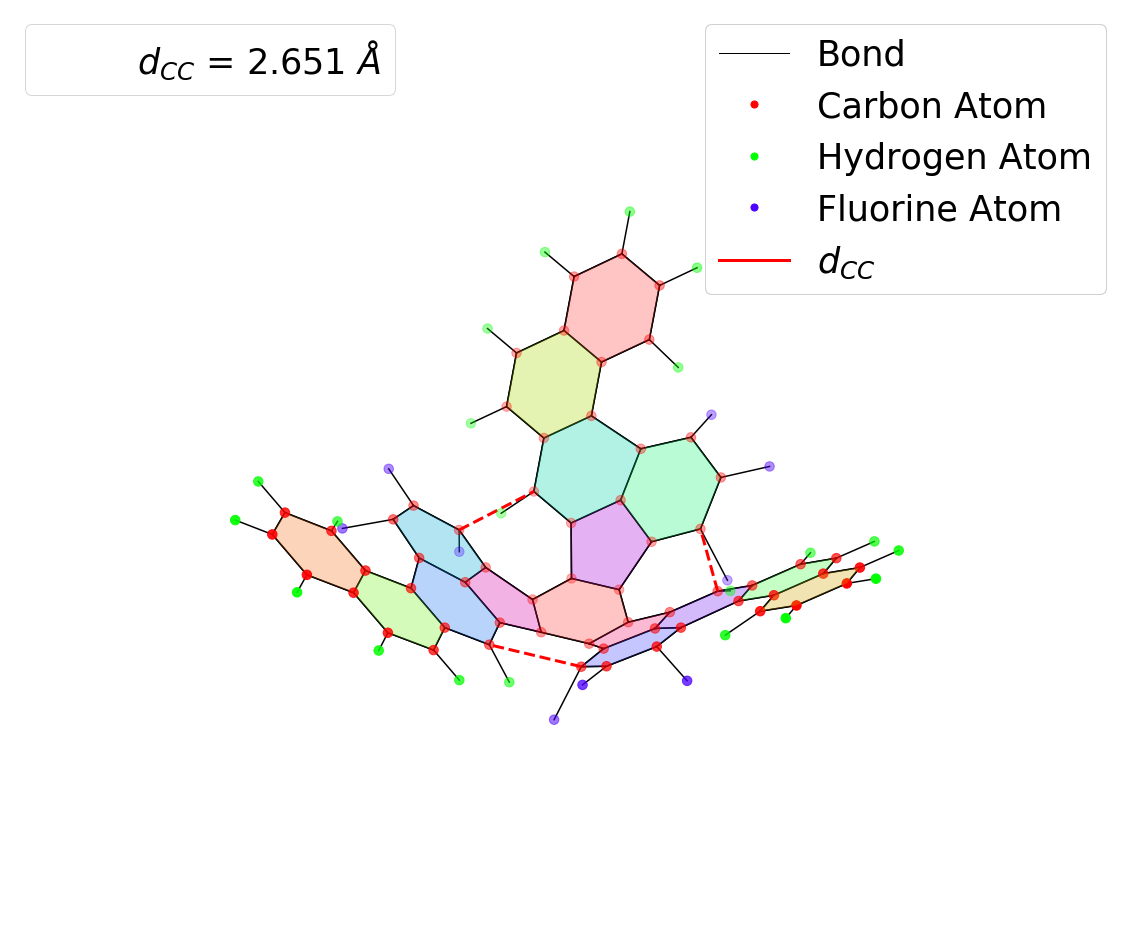

In [16]:

fig = plt.figure(figsize=(20,17))
elev, azim = 50,-10


geometry = geometries_F[-10,0]
C60.vertex_coords = geometry

ax2 = fig.add_subplot(projection='3d')
ax2, r2 = plot_graph_3D(C60, elev, azim, ax2, draw_dist=True,size=90)

ax2._axis3don = False
legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r2)]
legend = ax2.legend(handles=legend_element,loc="upper left",fontsize=35)
ax2.add_artist(legend)


handles, labels = ax2.get_legend_handles_labels()
legend_elements = [plt.Line2D([0], [0], color="k", lw=1, label='Bond'),
                    plt.Line2D([0], [0], marker='o', color='r',lw=0, label='Carbon Atom',markersize=7),
                    plt.Line2D([0], [0], marker='o', color=[0.,1.,0],lw=0, label='Hydrogen Atom',markersize=7),
                    plt.Line2D([0], [0], marker='o', color=[0.3,0.,1],lw=0, label='Fluorine Atom',markersize=7),
                   plt.Line2D([0], [0], color="r", lw=3, label='$d_{CC}$')]
    
legend1 = ax2.legend(handles=legend_elements,fontsize=35)
ax2.add_artist(legend1)
#fig.savefig("../../Illustrations/hinge_0_input.pdf", bbox_inches = 'tight', pad_inches = 0.3)


3.083
2.851
2.601
2.351
2.101
1.851
1.499
1.252


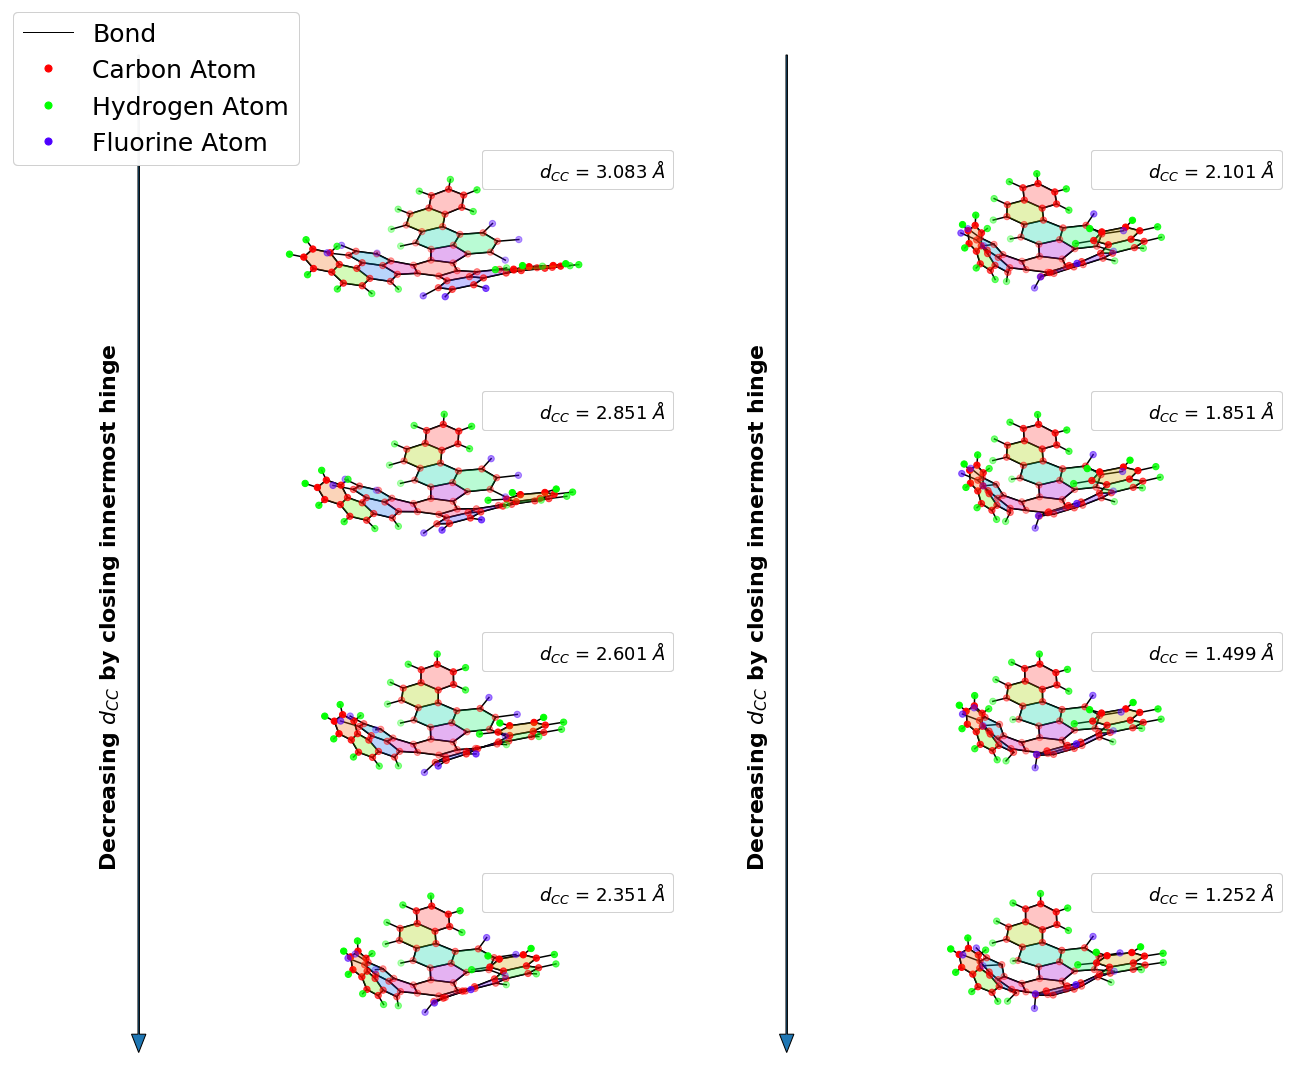

In [17]:
graph = C60
geometries = geometries_F
fig = plt.figure(figsize=(20,17))
elev, azim = 60,-10

n_plots = 8
id_geometry = np.flip(np.linspace(0,len(geometries)-1,n_plots,dtype=int))
evens = [n for n in range(n_plots) if n % 2 == 0]
unevens = [n for n in range(n_plots) if n % 2 != 0]
plot_position = np.hstack([evens,unevens]) + 1
for i in range(n_plots):
    geometry = geometries[id_geometry[i],-1]
    graph.vertex_coords = geometry
    
    ax = fig.add_subplot(n_plots//2, 2, plot_position[i], projection='3d')
    ax, r = plot_graph_3D(graph, elev, azim, ax)
    ax._axis3don = False
    legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r)]
    legend = ax.legend(handles=legend_element,loc="upper right",fontsize=18)
    ax.add_artist(legend)
    
    if i ==0:
        handles, labels = ax.get_legend_handles_labels()
        legend_elements = [plt.Line2D([0], [0], color="k", lw=1, label='Bond'),
                           plt.Line2D([0], [0], marker='o', color='r',lw=0, label='Carbon Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.,1.,0],lw=0, label='Hydrogen Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.3,0.,1],lw=0, label='Fluorine Atom',markersize=7)]
        
        legend1 = fig.legend(handles=legend_elements,fontsize=25,loc='upper left')
        fig.add_artist(legend1)
        
l1 = FancyArrow(0.1, 0.95, 0.0, -0.8, transform=fig.transFigure, figure=fig,head_width=0.01)  
l2 = FancyArrow(0.55, 0.95, 0.0, -0.8, transform=fig.transFigure, figure=fig,head_width=0.01)
#l1 = plt.Line2D([0, 1], [0, 1], transform=fig.transFigure, figure=fig)
#l2 = plt.Line2D([0, 1], [1, 0], transform=fig.transFigure, figure=fig)

# Set legend
#fig.text(0.3, 0.94, 'No dispersion',fontweight='bold',  ha='center', va='center')
#fig.text(0.7, 0.94, 'Empirical dispersion', fontweight='bold', ha='center', va='center')
#fig.text(0.02, 0.2, 'M062X', fontweight='bold', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.5, 'Decreasing $d_{CC}$ by closing innermost hinge', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=22)
fig.text(0.53, 0.5, 'Decreasing $d_{CC}$ by closing innermost hinge', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=22)

fig.lines.extend([l1, l2])
#fig.savefig("../../Illustrations/geometry_F_hinge_0.pdf")

3.083
2.901
2.7
2.501
2.351
2.15
1.951
1.801


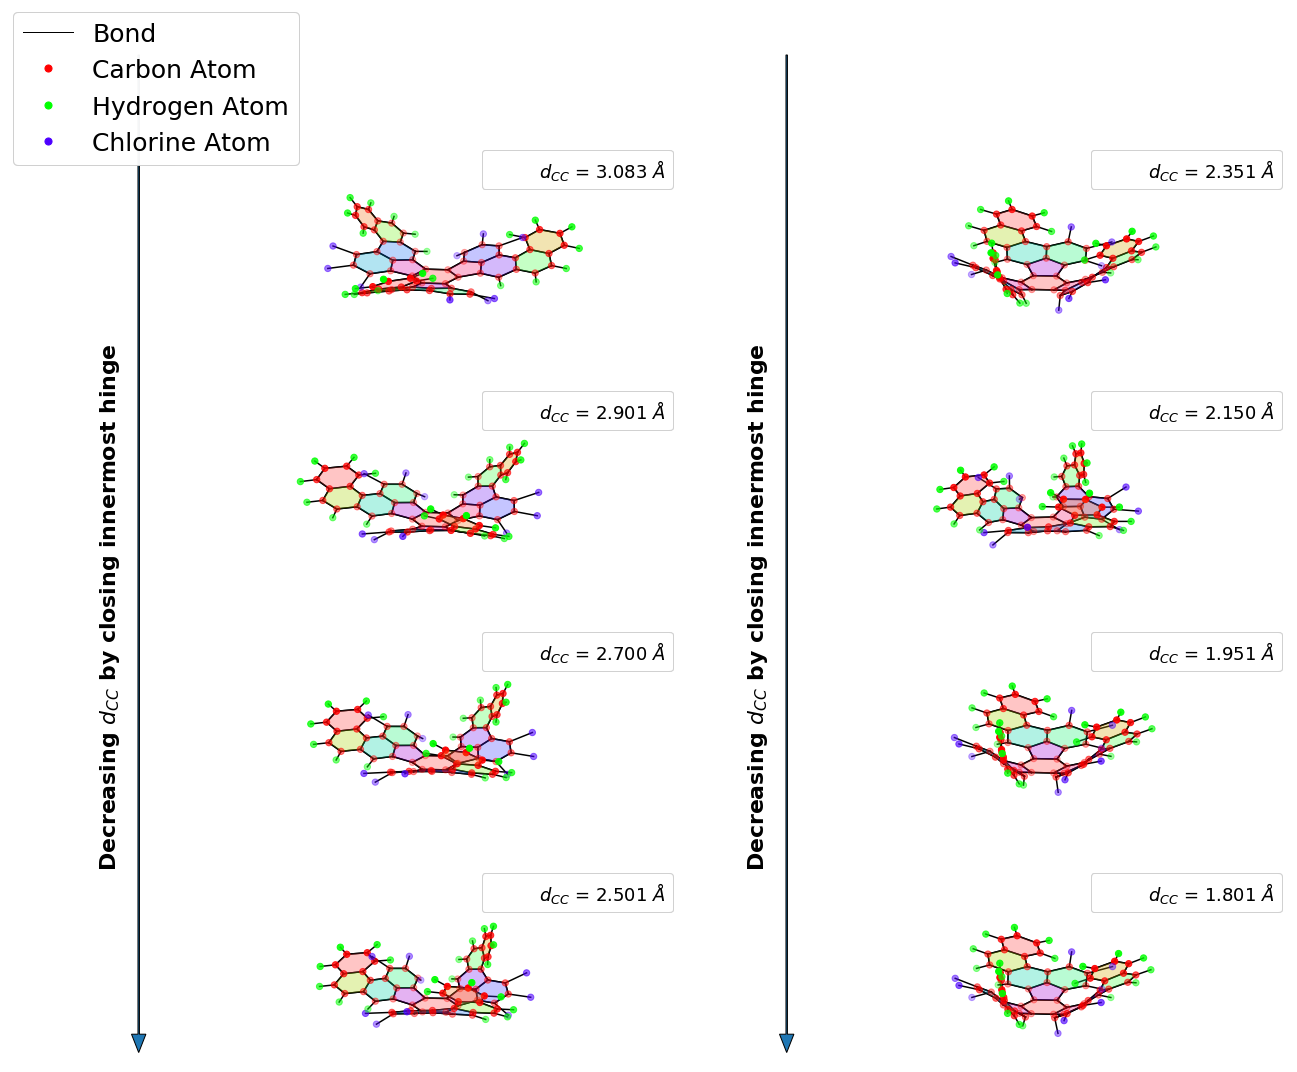

In [18]:
graph = C60
geometries = geometries_Cl

fig = plt.figure(figsize=(20,17))
elev, azim = 60,-10

n_plots = 8
id_geometry = np.flip(np.linspace(0,len(geometries)-1,n_plots,dtype=int))
evens = [n for n in range(n_plots) if n % 2 == 0]
unevens = [n for n in range(n_plots) if n % 2 != 0]
plot_position = np.hstack([evens,unevens]) + 1
for i in range(n_plots):
    geometry = geometries[id_geometry[i],-1]
    elev, azim = 60,-10
    if i ==0:
        geometry[:,0] *= -1.
        geometry[:,1] *= -1.
        geometry[:,2] *= -1.
        elev, azim = 60, -40
    graph.vertex_coords = geometry
    
    ax = fig.add_subplot(n_plots//2, 2, plot_position[i], projection='3d')
    ax, r = plot_graph_3D(graph, elev, azim, ax)
    ax._axis3don = False
    legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r)]
    legend = ax.legend(handles=legend_element,loc="upper right",fontsize=18)
    ax.add_artist(legend)
    
    if i ==0:
        handles, labels = ax.get_legend_handles_labels()
        legend_elements = [plt.Line2D([0], [0], color="k", lw=1, label='Bond'),
                           plt.Line2D([0], [0], marker='o', color='r',lw=0, label='Carbon Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.,1.,0],lw=0, label='Hydrogen Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.3,0.,1],lw=0, label='Chlorine Atom',markersize=7)]
        
        legend1 = fig.legend(handles=legend_elements,fontsize=25,loc='upper left')
        fig.add_artist(legend1)
        
l1 = FancyArrow(0.1, 0.95, 0.0, -0.8, transform=fig.transFigure, figure=fig,head_width=0.01)  
l2 = FancyArrow(0.55, 0.95, 0.0, -0.8, transform=fig.transFigure, figure=fig,head_width=0.01)
#l1 = plt.Line2D([0, 1], [0, 1], transform=fig.transFigure, figure=fig)
#l2 = plt.Line2D([0, 1], [1, 0], transform=fig.transFigure, figure=fig)

# Set legend
#fig.text(0.3, 0.94, 'No dispersion',fontweight='bold',  ha='center', va='center')
#fig.text(0.7, 0.94, 'Empirical dispersion', fontweight='bold', ha='center', va='center')
#fig.text(0.02, 0.2, 'M062X', fontweight='bold', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.5, 'Decreasing $d_{CC}$ by closing innermost hinge', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=22)
fig.text(0.53, 0.5, 'Decreasing $d_{CC}$ by closing innermost hinge', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=22)

fig.lines.extend([l1, l2])
#fig.savefig("../../Illustrations/geometry_Cl_hinge_0.pdf")

2.501
2.501


Text(0.75, 0.2, 'H & F placed inside')

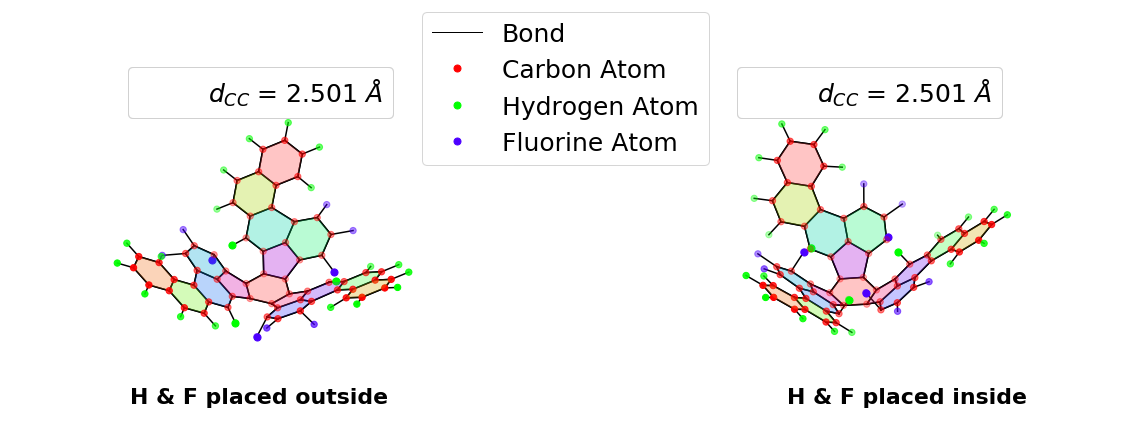

In [19]:
graph = C60
geometries = geometries_F_inside

fig = plt.figure(figsize=(20,7))
elev, azim = 60,-10

n_plots = 4
id_geometry = np.flip(np.linspace(0,len(geometries)-1,n_plots,dtype=int))

dist_B = d_CC_F_inside[-10]
dist_A = d_CC_F[-13]
geo_B = geometries_F_inside[-10,0]
geo_A = geometries_F[-13,0]

elev, azim = 60,-10

graph.vertex_coords = geo_A
ax = fig.add_subplot(1, 2 , 1, projection='3d')
ax, r = plot_graph_3D(graph, elev, azim, ax,big_HF=50)
ax._axis3don = False
legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r)]
legend = ax.legend(handles=legend_element,loc="upper center",fontsize=25)
ax.add_artist(legend)

graph.vertex_coords = geo_B
ax = fig.add_subplot(1, 2 , 2, projection='3d')
ax, r = plot_graph_3D(graph, elev, azim, ax,big_HF=50)
ax._axis3don = False
legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r)]
legend = ax.legend(handles=legend_element,loc="upper center",fontsize=25)
ax.add_artist(legend)

handles, labels = ax.get_legend_handles_labels()
legend_elements = [plt.Line2D([0], [0], color="k", lw=1, label='Bond'),
                           plt.Line2D([0], [0], marker='o', color='r',lw=0, label='Carbon Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.,1.,0],lw=0, label='Hydrogen Atom',markersize=7),
                           plt.Line2D([0], [0], marker='o', color=[0.3,0.,1],lw=0, label='Fluorine Atom',markersize=7)]
        
legend1 = fig.legend(handles=legend_elements,fontsize=25,loc='upper center')
##fig.add_artist(legend1)
        
#l1 = FancyArrow(0.1, 0.05, 0.8, 0., transform=fig.transFigure, figure=fig, head_width=0.02)  

fig.text(0.3, 0.2, 'H & F placed outside', fontweight='bold', ha='center', va='center', fontsize=22)
fig.text(0.75, 0.2, 'H & F placed inside', fontweight='bold', ha='center', va='center', fontsize=22)

#fig.savefig("../../Illustrations/geometry_F_inside_input.pdf")

1.601


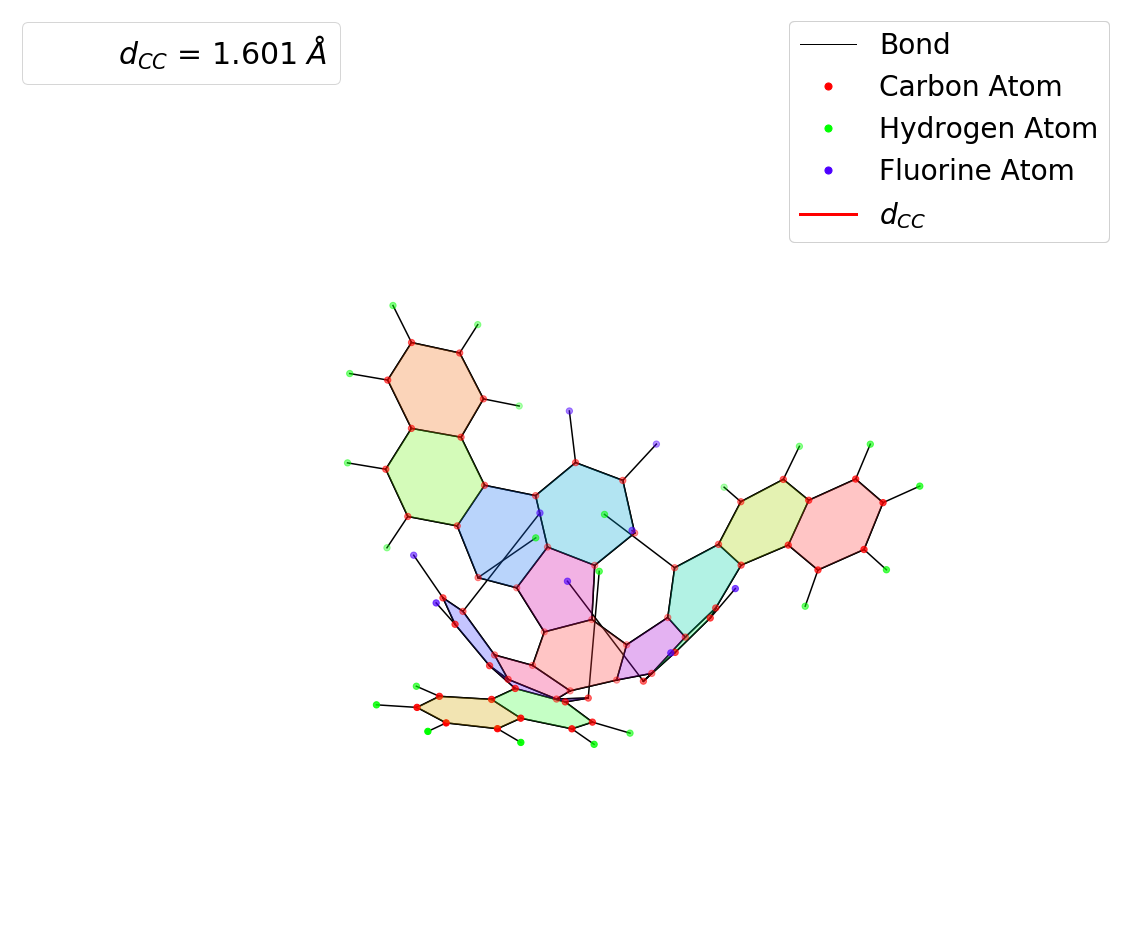

In [20]:
fig = plt.figure(figsize=(20,17))
elev, azim = 60, 40


geometry = geometries_F_inside[0,-1]
C60.vertex_coords = geometry

ax2 = fig.add_subplot(projection='3d')
ax2, r2 = plot_graph_3D(C60, elev, azim, ax2)

#geometry[:,0] *= -1.
geometry[:,1] *= -1.
#geometry[:,2] *= -1.


ax2._axis3don = False
legend_element = [plt.Line2D([0], [0], color="k", lw=0, label='$d_{CC}$ = %.3f $\AA$' %r2)]
legend = ax2.legend(handles=legend_element,loc="upper left",fontsize=30)
ax2.add_artist(legend)


handles, labels = ax2.get_legend_handles_labels()
legend_elements = [plt.Line2D([0], [0], color="k", lw=1, label='Bond'),
                    plt.Line2D([0], [0], marker='o', color='r',lw=0, label='Carbon Atom',markersize=7),
                    plt.Line2D([0], [0], marker='o', color=[0.,1.,0],lw=0, label='Hydrogen Atom',markersize=7),
                    plt.Line2D([0], [0], marker='o', color=[0.3,0.,1],lw=0, label='Fluorine Atom',markersize=7),
                   plt.Line2D([0], [0], color="r", lw=3, label='$d_{CC}$')]
    
legend1 = ax2.legend(handles=legend_elements,fontsize=28)
ax2.add_artist(legend1)
##fig.savefig("../../Illustrations/hinge_0_input.pdf")